### Clean Data

- Change column names to make it easier to write code with
- Filter values to only include positions within valid regions of the pitch
- Sort the values for more efficient grouping
- Map IDs to new values for more interpretability

In [ ]:
import pandas as pd
import numpy as np


df = pd.read_csv('match_data.csv')
df.rename(columns={'Pitch_x': 'x', 'Pitch_y' : 'y',
                   'participation_id' : 'id' , 'Time (s)': 
                   'time', 'Speed (m/s)': 'speed'}, inplace=True)

# Arsenal Women's team players for the match against Real Madrid
new_names = ['Emily', 'Steph', 'Laia', 'Leah',
             'Alessia', 'Katie', 'Mariona', 'Lia',
             'Daphne', 'Frida', 'Kim', 'Chloe', 
             'Kyra', 'Stina', 'Beth']

df['id'] = df[(df['id'] != 'ball')]['id'].map(dict(zip(df['id'].unique(), new_names)))
df['id'] = df['id'].fillna('ball')

df = df[(df['x'] > -52.5) &
        (df['x'] < 52.5) &
        (df['y'] > -34) &
        (df['y'] < 34) &
        (df['speed'] > 0) # trackers were not moving and were all in the same location
        ] 

df.sort_values(by=['id', 'time'], inplace=True)

['Emily' 'Steph' 'Laia' 'Leah' 'Alessia' 'Katie' 'Mariona' 'Lia' 'Daphne'
 'Frida' 'Kim' 'Chloe' 'Kyra' 'Stina' 'ball']


### Leaderboard Generation
Create a leaderboard ranking athletes based on the three key metrics:
1. Total Distance – The total distance covered by each athlete.
2. Distance at Speed Zone 5 – The cumulative distance an athlete runs while moving at a speed
between 19.8 km/h and 25.1 km/h.
3. Top Speed – The highest speed recorded for each athlete.

In [28]:
lboard1 = df[df['id'] != 'ball'][['id', 'x', 'y']] 
total_distances = (
    lboard1.groupby('id')
    .apply(lambda x: np.sqrt((x['x'].diff()**2) +
                             (x['y'].diff()**2)).sum(),
                             include_groups=False)
    .reset_index(name='total_distance')
    .sort_values('total_distance', ascending=False) 
    .reset_index(drop=True)
)
print(total_distances)

         id  total_distance
0      Kyra    11997.300936
1   Alessia    11517.437233
2       Lia    11450.617449
3     Frida    11015.236440
4       Kim     9969.641081
5   Mariona     9709.671493
6     Chloe     8536.513427
7    Daphne     8217.648173
8     Katie     7745.246281
9     Stina     4276.831954
10    Steph     3115.694337
11    Emily     1598.497534
12     Leah      991.271944
13     Laia      982.629093


In [46]:
lboard2 = df[(df['id'] != 'ball') &
             (df['speed'] > 5.5) &
             (df['speed'] < 6.97)][['id', 'x', 'y']]

distance_zone2 = (
    lboard2.groupby('id')
    .apply(lambda x: np.sqrt((x['x'].diff()**2) +
                             (x['y'].diff()**2)).sum(),
                             include_groups=False)
    .reset_index(name='distance_zone2')
    .sort_values('distance_zone2', ascending=False) 
    .reset_index(drop=True)
)

print(distance_zone2)

         id  distance_zone2
0     Frida     2461.970263
1      Kyra     2359.354563
2       Kim     1423.309597
3   Alessia     1216.034475
4   Mariona      941.911000
5     Chloe      913.869905
6    Daphne      805.991163
7       Lia      719.581942
8     Katie      706.193814
9     Steph      548.841893
10    Stina      449.473451
11    Emily      125.372260
12     Laia       65.194673


### Max Speed
- Filter for relevant columns
- Perform the groupby, apply the function and sort ascending

In [30]:
lboard3 = df[df['id'] != 'ball'][['id', 'speed']]
max_speed = lboard3.groupby('id').max().sort_values('speed', ascending=False)

print(max_speed)

         speed
id            
Frida    8.200
Laia     7.789
Mariona  7.693
Kim      7.683
Steph    7.559
Daphne   7.528
Kyra     7.136
Chloe    7.076
Stina    6.997
Alessia  6.990
Katie    6.969
Lia      6.724
Emily    6.644
Leah     3.693


### Heatmap

- Heatmap of player positions
- Smoothed with Gaussian filter for easier visualisation
- concentration in the corner suggests that there was a celebration

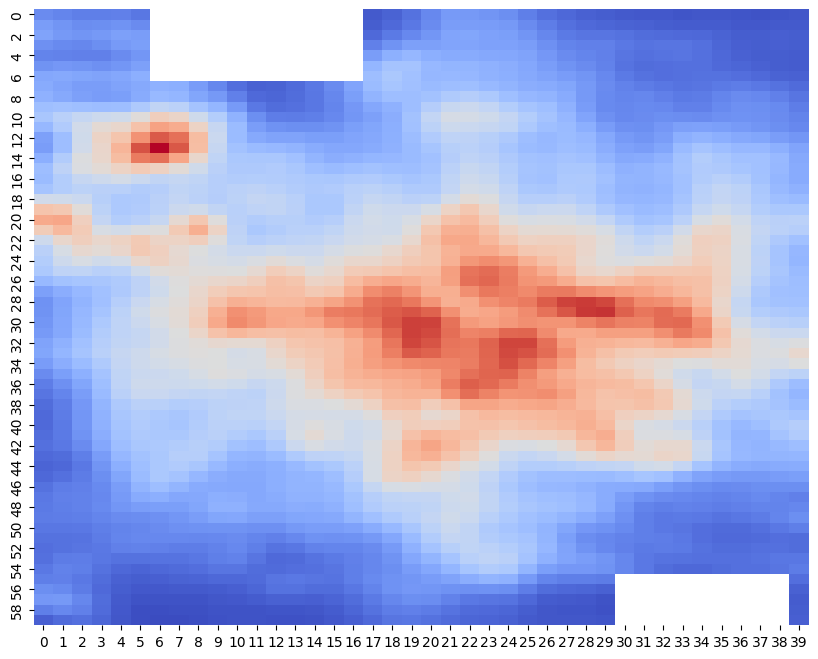

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter


plot_df = df

# round the values up to 1 decimal place so the heatmap is not too granular
plot_df.round({"x": 1, "y": 1})
plt.figure(figsize = (10,8))

# bin the x and y values to make the heatmap less granular, 60/40 chosen to maintain the ratio of the pitch
plot_df['x'] = pd.cut(plot_df['x'], bins=60, labels=False)
plot_df['y'] = pd.cut(plot_df['y'], bins=40, labels=False)

position_counts = plot_df.groupby(['x', 'y']).size().sort_values(ascending=False).reset_index(name='counts')

# smooth the heatmap
pos_smooth = gaussian_filter(position_counts.pivot(index='x', columns='y', values='counts'), sigma=1)
sns.heatmap(pos_smooth, cmap='coolwarm', cbar=False)


plt.show()


### Posession

- Determine players posession numbers based on their proximity to the ball (very rough estimate and method)
- Can also be used for any two players

In [50]:

from collections import defaultdict

def time_spent(df, target_id, proximity_threshold=3):

    time_groups = df.groupby('time')
    time_with_others = defaultdict(int)

    for time, group in time_groups:
        # Get target's coordinates at this time
        target_data = group[group['id'] == target_id]
        if target_data.empty:
            continue  
        
        x_target = target_data['x'].values[0]
        y_target = target_data['y'].values[0]
        
        # Compute Euclidean distance from target to all others at this time
        group['distance'] = np.sqrt(
            (group['x'] - x_target) ** 2 + 
            (group['y'] - y_target) ** 2
        )
        
        # Filter IDs within proximity threshold (excluding itself)
        nearby_ids = group[(group['distance'] <= proximity_threshold) & 
                           (group['id'] != target_id)]['id'].tolist()
        
        # Increment time spent with each nearby ID (assuming 0.1 time unit per row)
        for other_id in nearby_ids:
            time_with_others[other_id] += 0.1

    time_with_others = dict(sorted(time_with_others.items(), key=lambda item: item[1], reverse=True))
    for k,v in time_with_others.items():
        print(f'{target_id} spent approximately {v:.1f} seconds with {k}')

time_spent(df, 'ball')

ball spent approximately 75.8 seconds with Kim
ball spent approximately 45.0 seconds with Kyra
ball spent approximately 40.3 seconds with Alessia
ball spent approximately 36.8 seconds with Frida
ball spent approximately 21.2 seconds with Lia
ball spent approximately 20.4 seconds with Chloe
ball spent approximately 16.1 seconds with Katie
ball spent approximately 12.2 seconds with Steph
ball spent approximately 8.7 seconds with Mariona
ball spent approximately 3.5 seconds with Stina
ball spent approximately 2.7 seconds with Daphne
ball spent approximately 0.6 seconds with Leah
